Trabajaremos con un conjunto de datos de correo electrónico no deseado (el mismo que en el Notebook de Bagging). El conjunto de datos tiene 57 predictores con una variable de respuesta llamada `Spam` que indica si un correo electrónico es spam o no. **El objetivo es poder crear un clasificador o método que actúe como un filtro de spam.**

Más información: https://archive.ics.uci.edu/ml/datasets/spambase

In [12]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
##CUIDADO!!: este paquete quizás es nuevo para nosotros
from tqdm import tqdm
import sklearn.metrics as metrics
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.model_selection import learning_curve

In [3]:
#Importar Dataframe y poner los nombres de las columnas
spam_df = pd.read_csv('spam.csv', header=None)
columns = ["Column_"+str(i+1) for i in range(spam_df.shape[1]-1)] + ['Spam']
spam_df.columns = columns
display(spam_df.head())

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,Column_11,Column_12,Column_13,Column_14,Column_15,Column_16,Column_17,Column_18,Column_19,Column_20,Column_21,Column_22,Column_23,Column_24,Column_25,Column_26,Column_27,Column_28,Column_29,Column_30,Column_31,Column_32,Column_33,Column_34,Column_35,Column_36,Column_37,Column_38,Column_39,Column_40,Column_41,Column_42,Column_43,Column_44,Column_45,Column_46,Column_47,Column_48,Column_49,Column_50,Column_51,Column_52,Column_53,Column_54,Column_55,Column_56,Column_57,Spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Para validar el resultado sencillamente usamos Hold-out (70%30%)

In [6]:
#Dividir los datos en Training y Test usando valores aleatorios de una distribución uniforme
np.random.seed(42)
msk = np.random.rand(len(spam_df)) < 0.7
data_train = spam_df[msk]
data_test = spam_df[~msk]

#Split predictor and response columns
x_train, y_train = data_train.drop(['Spam'], axis=1), data_train['Spam']
x_test , y_test  = data_test.drop(['Spam'] , axis=1), data_test['Spam']

print("Shape of Training Set :",data_train.shape)
print("Shape of Testing Set :" ,data_test.shape)

Shape of Training Set : (3262, 58)
Shape of Testing Set : (1339, 58)


In [7]:
#Verificar la cantidad de casos de Spam
percentage_spam_training = 100*y_train.sum()/len(y_train)
percentage_spam_testing  = 100*y_test.sum()/len(y_test)
                                                  
print("Percentage of Spam in Training Set \t : {:0.2f}%.".format(percentage_spam_training))
print("Percentage of Spam in Testing Set \t : {:0.2f}%.".format(percentage_spam_testing))

Percentage of Spam in Training Set 	 : 39.18%.
Percentage of Spam in Testing Set 	 : 39.96%.


## ¿Qué es Boosting?

- **Bagging y Random Forest:**
  - Complejos árboles produndos **overfit**
  - por eso **vamos a procurar reducir la varianza en los árboles!**
- **Boosting:** 
  - árboles simples y poco profundos **underfit** 
  - en este caso **hay que reducir bias en árboles sencillos!**
  - hacer que los árboles simples sean más expresivos!
  
**Boosting** intenta mejorar la flexibilidad predictiva de modelos simples.
 - Entrena a un **gran número de modelos "débiles" en secuencia**.
 - Un modelos débil es un modelo restringido (limite la profundidad máxima de cada árbol de decisión).
 - Cada uno en la secuencia se enfoca en **aprender de los errores** del anterior..
 - Al ponderar más los errores en el próximo árbol, nuestro próximo árbol aprenderá de los errores.
 - Una combinación de todos los estudiantes débiles en un solo modelo fuerte = **boosted tree**.

### Qué es Ada Boost?

- Ada Boost = Adaptive Boosting.
- AdaBoost es adaptativo en el sentido de que los posteriores modelos débiles se modifican en favor de aquellas instancias clasificadas erróneamente por clasificadores anteriores

**Dado que cuando $\hat{y}_n = 𝑦_n$, el peso $w_n$ es pequeño; cuando $\hat{y}_n \neq 𝑦_n$, el peso $w_n$ is grande.**

## Vamos a utilizar AdaBoost para analizar el balance entre Bias-Variance.

In [8]:
#Ajustamos un modelo Adaboost

#Training
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), 
                           n_estimators=200, 
                           learning_rate=0.05)
model.fit(x_train, y_train)

#Predict
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

#Evaluación
acc_boosting_training = accuracy_score(y_train, y_pred_train)*100
acc_boosting_test = accuracy_score(y_test, y_pred_test)*100

print("Ada Boost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_boosting_training))
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))

Ada Boost:	Accuracy, Training Set 	: 99.60%
Ada Boost:	Accuracy, Testing Set 	: 94.62%


**¿Cómo evoluciona la precisión del test y del entrenamiento con cada iteración?**

**staged_score**: Este método genera el score del conjunto después de cada iteración y permite monitorizar el proceso de entrenamiento.

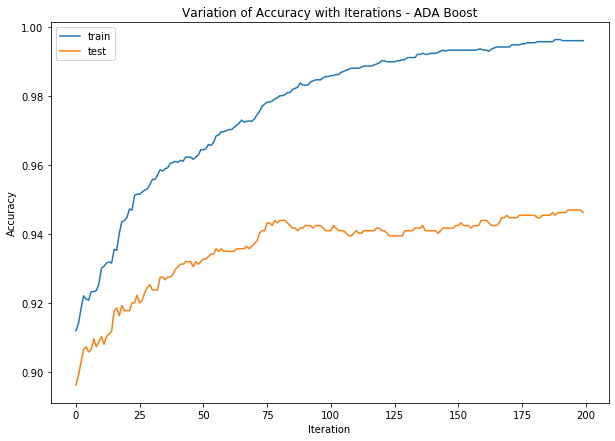

In [9]:
#Plot Iteration based score
train_scores = list(model.staged_score(x_train,y_train))
test_scores = list(model.staged_score(x_test, y_test))

plt.figure(figsize=(10,7))
plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Variation of Accuracy with Iterations - ADA Boost")
plt.legend();

In [10]:
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))

Ada Boost:	Accuracy, Testing Set 	: 94.62%


**Tip:** Si un bucle "for" lleva algo de tiempo y se desea conocer el progreso mientras se ejecuta el bucle, usar: **tqdm()** ([link](https://github.com/tqdm/tqdm)). 


Uso: ```for i in tqdm( range(start,finish) ):```

#### ¿Qué pasa si cambiamos la profundidad de los árboles en AdaBoost?

In [13]:
# Start Timer
start = time.time()

#Encontrar la profundidad optima para los árboles en Boosting
score_train, score_test, depth_start, depth_end = {}, {}, 2, 30
for i in tqdm(range(depth_start, depth_end, 2)):
    model = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=i),
        n_estimators=200, learning_rate=0.05)
    model.fit(x_train, y_train)
    score_train[i] = accuracy_score(y_train, model.predict(x_train))
    score_test[i] = accuracy_score(y_test, model.predict(x_test))
    
# Stop Timer
end = time.time()
elapsed_adaboost = end - start

100%|██████████| 14/14 [01:38<00:00,  7.07s/it]


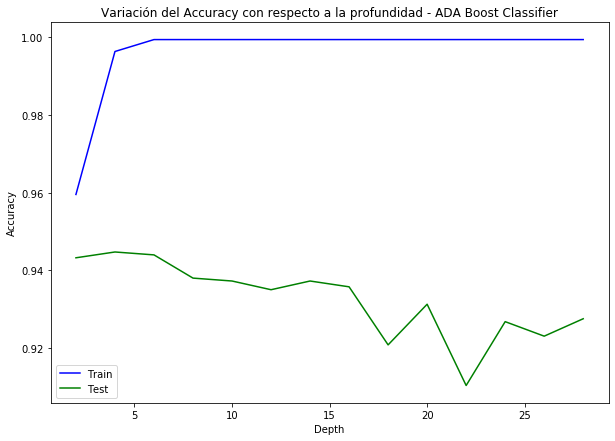

In [15]:
#Plot
lists1 = sorted(score_train.items())
lists2 = sorted(score_test.items())
x1, y1 = zip(*lists1) 
x2, y2 = zip(*lists2) 
plt.figure(figsize=(10,7))
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.title('Variación del Accuracy con respecto a la profundidad - ADA Boost Classifier')
plt.plot(x1, y1, 'b-', label='Train')
plt.plot(x2, y2, 'g-', label='Test')
plt.legend()
plt.show()

La complejidad de Adaboost depende tanto del número de estimadores como del estimador base.
- Al principio, a medida que aumenta la complejidad de nuestro modelo (profundidad 2-3), primero observamos un pequeño aumento en la precisión.
- Pero a medida que avanzamos hacia la derecha del gráfico (**árboles más profundos**), nuestro modelo **sobreajusta los datos**
- **RECORDATORIO: ¡Boosting se basa en árboles simples! **

- ¿Son **los modelos potenciados independientes unos de otros?** ¿Necesitan esperar los residuos del modelo anterior?

## Recordamos qué Gradient Boosting y XGBoost

### ¿Qué es Gradient Boosting?

Para mejorar sus predicciones, el aumento de gradiente **observa la diferencia entre la predicción actual y el valor medido conocido conocido, que se llama residuo**.

- Se puede suponer que hay algún modelo imperfecto $F_{m}$ 
- El algoritmo gradient boosting mejora $F_{m}$ construyendo un nuevo modelo que agrega un estimador $h$ para proporcionar un mejor modelo: 
$$F_{m+1}(x)=F_{m}(x)+h(x)$$

- El modelo nuevo creado ajustará el residuo $y-F_{m}(x)$


----------

### ¿Qué es XGBoost por qué da tam buenos resultados!?
- Basado en Gradient Boosting
 - XGBoost = **eXtreme Gradient Boosting**; impulsar el límite los recursos de computación en la aproximación boosting
 
**Accuracy:**
 - XGBoost, sin embargo, utiliza una **formalización de modelo más regularizada para controlar el sobreajuste** (= mejor rendimiento) por la regularización de L1 y L2.
 - Métodos de poda de árboles: un árbol menos profundo también evitará el sobreajuste
 - Técnicas de convergencia mejoradas (como la detención temprana cuando no se realiza ninguna mejora para X número de iteraciones)
 - Validación cruzada incorporada
 
**Velocidad de cómputo:**
 - Estructuras de datos especiales tipo Vector y matriz para obtener resultados más rápidos.
 - Construcción de árboles en paralelo: utiliza todos los núcleos de tu CPU durante el entrenamiento.
 - Computación distribuida: para entrenar modelos muy grandes utilizando un grupo de máquinas.
 - Optimización de caché de estructuras de datos y algoritmos: para aprovechar al máximo el hardware.

**XGBoost está construyendo árboles boost en paralelo? ¿Qué? ¿Cómo?**
- No: Xgboost no ejecuta varios árboles en paralelo, necesita predicciones después de cada árbol para actualizar los gradientes.
- En lugar de eso, hace la paralelización DENTRO de un solo árbol usando OpenMP para crear ramas de forma independiente.

## Vamos a probar XGBoost: Extreme Gradient Boosting

In [10]:
# Let's install XGBoost
! pip install xgboost

     |████████████████████████████████| 109.8MB 68kB/s  eta 0:00:01   |▎                               | 983kB 946kB/s eta 0:01:55     |▌                               | 1.7MB 946kB/s eta 0:01:55     |▊                               | 2.3MB 1.9MB/s eta 0:00:58     |▉                               | 2.7MB 1.9MB/s eta 0:00:58     |███▏                            | 10.9MB 1.6MB/s eta 0:01:04     |█████████                       | 30.6MB 2.0MB/s eta 0:00:41     |█████████                       | 30.7MB 2.0MB/s eta 0:00:41     |█████████                       | 31.0MB 2.0MB/s eta 0:00:41     |██████████████▍                 | 49.3MB 2.2MB/s eta 0:00:28     |███████████████                 | 51.8MB 1.9MB/s eta 0:00:32     |███████████████▍                | 52.7MB 1.6MB/s eta 0:00:37     |████████████████                | 54.8MB 1.6MB/s eta 0:00:35     |███████████████████▏            | 65.8MB 1.5MB/s eta 0:00:30     |███████████████████████▎        | 79.8MB 953kB/s eta 0:00:32     |█████████

In [18]:
# Según lo anterior vamos establecer best_depth a 7
best_depth = 7


In [17]:
import xgboost as xgb

# Create the training and test data
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Parameters
param = {
    'max_depth': best_depth,  # the maximum depth of each tree
    'eta': 0.3,               # the training step for each iteration
    'silent': 1,              # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}           # the number of classes that exist in this datset

# Number of training iterations
num_round = 200  

# Start timer
start = time.time()

# Train XGBoost
bst = xgb.train(param, 
                dtrain, 
                num_round, 
                evals= [(dtrain, 'train')], 
                early_stopping_rounds=20, # early stopping
                verbose_eval=20)


# Make prediction training set
preds_train = bst.predict(dtrain)
best_preds_train = np.asarray([np.argmax(line) for line in preds_train])

# Make prediction test set
preds_test = bst.predict(dtest)
best_preds_test = np.asarray([np.argmax(line) for line in preds_test])

# Performance Evaluation 
acc_XGBoost_training = accuracy_score(y_train, best_preds_train)*100
acc_XGBoost_test = accuracy_score(y_test, best_preds_test)*100

# Stop Timer
end = time.time()
elapsed_xgboost = end - start

print("XGBoost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_XGBoost_training))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

[0]	train-merror:0.05794
Will train until train-merror hasn't improved in 20 rounds.
[20]	train-merror:0.01410
[40]	train-merror:0.00552
[60]	train-merror:0.00153
[80]	train-merror:0.00061
[100]	train-merror:0.00061
Stopping. Best iteration:
[80]	train-merror:0.00061

XGBoost:	Accuracy, Training Set 	: 99.94%
XGBoost:	Accuracy, Testing Set 	: 95.07%


### Comparamos fiabilidad: AdaBoost versus XGBoost?

In [19]:
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

Ada Boost:	Accuracy, Testing Set 	: 94.62%
XGBoost:	Accuracy, Testing Set 	: 95.07%


### Comparamos coste computacional: AdaBoost versus XGBoost?

In [20]:
print("AdaBoost elapsed time: \t{:0.2f}s".format(elapsed_adaboost))
print("XGBoost elapsed time: \t{:0.2f}s".format(elapsed_xgboost))

AdaBoost elapsed time: 	98.96s
XGBoost elapsed time: 	3.02s


### Vamos a analizar la profundidad del árbol en XGBoost trees vs. AdaBoost

In [21]:
def model_xgboost(best_depth):
    param = {
    'max_depth': best_depth,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset

    # the number of training iterations
    num_round = 200  

    bst = xgb.train(param, 
                    dtrain, 
                    num_round, 
                    evals= [(dtrain, 'train')], 
                    early_stopping_rounds=20,
                    verbose_eval=False)

    preds_train = bst.predict(dtrain)
    best_preds_train = np.asarray([np.argmax(line) for line in preds_train])
    preds_test = bst.predict(dtest)
    best_preds_test = np.asarray([np.argmax(line) for line in preds_test])

    #Performance Evaluation
    XGBoost_training = accuracy_score(y_train, best_preds_train)
    XGBoost_test = accuracy_score(y_test, best_preds_test)
    
    return XGBoost_training, XGBoost_test

In [22]:
#Find Optimal Depth of trees for Boosting
score_train_xgb, score_test_xgb = {}, {}
depth_start, depth_end = 2, 30
for i in tqdm(range(depth_start, depth_end, 2)):
    XGBoost_training, XGBoost_test = model_xgboost(i)
    score_train_xgb[i] = XGBoost_training
    score_test_xgb[i] = XGBoost_test

100%|██████████| 14/14 [00:27<00:00,  1.93s/it]


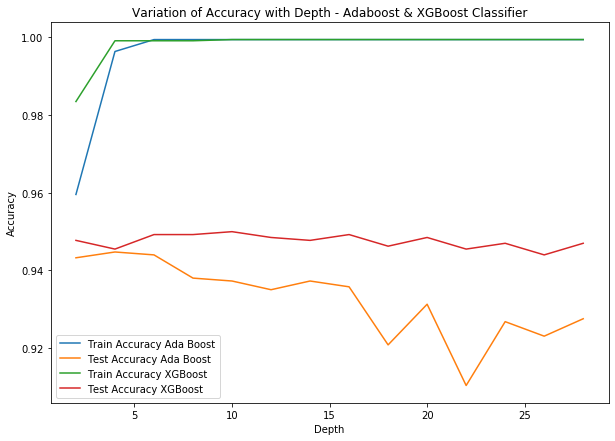

In [23]:
#Plot
lists1 = sorted(score_train_xgb.items())
lists2 = sorted(score_test_xgb.items())
x3, y3 = zip(*lists1) 
x4, y4 = zip(*lists2) 
plt.figure(figsize=(10,7))
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.title('Variation of Accuracy with Depth - Adaboost & XGBoost Classifier')
plt.plot(x1, y1, label='Train Accuracy Ada Boost')
plt.plot(x2, y2, label='Test Accuracy Ada Boost')
plt.plot(x3, y3, label='Train Accuracy XGBoost')
plt.plot(x4, y4, label='Test Accuracy XGBoost')
plt.legend()
plt.show()

**Cosas interesantes**: 
- No hay una profundidad óptima de lps árboles para XGBoost, probablemente mucha regularización, poda o parada temprana cuando se usa un árbol profundo al comienzo.
- XGBoost no parece sobreajustarse demasiado cuando aumenta la profundidad del árbol, a diferencia de Ada Boost.

**All the accuracy performances:**

In [24]:
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

Ada Boost:	Accuracy, Testing Set 	: 94.62%
XGBoost:	Accuracy, Testing Set 	: 95.07%
